In [1]:
!nvidia-smi

Thu Oct 20 22:07:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install textblob 'gensim==4.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 3.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [66]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import pickle
from tensorflow.nn import leaky_relu

import re
import warnings
from sklearn.model_selection import train_test_split
from textblob import TextBlob

TRACE = False
embedding_dim = 300
epochs=100
batch_size = 250
corpus_size=25000
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
%%writefile get_data.sh
if [ ! -f news.csv ]; then
  wget -O news.csv https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
fi

if [ ! -f emb_word2vec_format.txt ]; then
    wget -O emb_word2vec_format.txt https://www.dropbox.com/s/cqoacnovxsq1zoe/emb_word2vec_format.txt?dl=0
fi

Overwriting get_data.sh


In [68]:
!bash get_data.sh

In [69]:
path = './news.csv'
news = pd.read_csv(path, header=0).sample(n=corpus_size).reset_index(drop=True)
print(news.title)

0             BBC set for major shake-up, claims newspaper
1                                 Marsh averts cash crunch
2                 Jeter, Yankees Look to Take Control (AP)
3                                 Flying the Sun to Safety
4                 Stocks Seen Flat as Nortel and Oil Weigh
                               ...                        
24995      Wal-Mart Clarifies Policy Regarding Unions (AP)
24996    VIEWPOINT: Better Russian planning would preve...
24997                      No. 6 Syracuse 56, Princeton 45
24998         USC, Oklahoma Still 1-2, Auburn Third in BCS
24999                        Giggs returns to face England
Name: title, Length: 25000, dtype: object


In [70]:
def preprocess_text(text, should_join=True):
    # Use the tokenizer to tokenize into words, lowercase them, remove punctuation, and finally use gensim.utils.simple_preprocess(text)
    text = ' '.join(text.lower().split())

    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [71]:
news.title.apply(preprocess_text)
news

,category,title
0,Business,"BBC set for major shake-up, claims newspaper"
1,Business,Marsh averts cash crunch
2,Sports,"Jeter, Yankees Look to Take Control (AP)"
3,Sci/Tech,Flying the Sun to Safety
4,Business,Stocks Seen Flat as Nortel and Oil Weigh
...,...,...
24995,Business,Wal-Mart Clarifies Policy Regarding Unions (AP)
24996,Sci/Tech,VIEWPOINT: Better Russian planning would preve...
24997,Sports,"No. 6 Syracuse 56, Princeton 45"
24998,Sports,"USC, Oklahoma Still 1-2, Auburn Third in BCS"


In [72]:

 
class MyCorpus:
   def __iter__(self):
        corpus_path = 'news.csv'
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield preprocess_text(line, should_join=False)

# Get a word2vec model using gensim.models and passing the sentences using MyCorpus()

import gensim.models
sentences = MyCorpus()
word2vec = gensim.models.word2vec.Word2Vec(sentences = sentences , vector_size=embedding_dim, min_count=2, epochs=3, workers=5)
word2vec_model = word2vec.wv



In [73]:
news['label'] = news.category.map({'Business': 0, 'Sports': 1, 'Sci/Tech': 2, 'World': 3})

weights = tf.constant(word2vec_model.vectors)
vocab_size = len(word2vec_model.index_to_key)

In [74]:
weights.shape

TensorShape([20893, 300])

In [75]:
def get_maximum_review_length(df):
    maximum = 0
    for ix, row in df.iterrows():
        candidate = len(tokenizer(row.title))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(news)   # Since 2 titles may have different number of words, we have to find the max length and fill with 0s if a title is shorter

In [60]:
X = np.zeros((len(news), maximum))   # Here we do what we said above
# Iterate through the news df and for every word, if it exists in the word2vec model, put into X for that review and that word the index of the embedding (check index_to_key)
# FILL
X = np.zeros((len(news), maximum))
for index, row in news.iterrows():
    ix = 0
    for word in tokenizer(row.title):
        if word not in word2vec_model:
            representation = 0
        else:
            representation = word2vec_model.index_to_key.index(word)
        X[index, ix] = representation
        ix += 1
y = news.label


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)
# Convert y_train and y_test from an array of values between 0-3 to a one hot matrix tensor
y_train = tf.one_hot(tf.constant(y_train), 4)
y_test = tf.one_hot(tf.constant(y_test), 4)
X_train[0]
weights.shape

TensorShape([20893, 300])

In [77]:
model = Sequential()
model.add(Embedding(input_dim=weights.shape[0], output_dim=embedding_dim, input_length=maximum, embeddings_initializer=Constant(weights), trainable=True))
model.add(Dense(100, activation=leaky_relu))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(None, embedding_dim,)))
model.add(Dense(50, activation=leaky_relu))
model.add(Dense(4, activation='softmax'))

In [80]:
# Compile the model. Think what is the best loss to use
model.compile(loss='categorical_crossentropy', optimizer='adam', steps_per_execution=len(X_train)//batch_size)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 300)           6267900   
                                                                 
 dense (Dense)               (None, 21, 100)           30100     
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 6,303,254
Trainable params: 6,303,254
Non-trainable params: 0
_________________________________________________________________


In [81]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), workers=5, callbacks=[callback])

Epoch 1/100
80/80 [==============================] - 4s 48ms/step - loss: 1.3633 - val_loss: 1.3061
Epoch 2/100
80/80 [==============================] - 0s 6ms/step - loss: 1.2194 - val_loss: 1.1789
Epoch 3/100
80/80 [==============================] - 0s 6ms/step - loss: 1.1048 - val_loss: 1.1327
Epoch 4/100
80/80 [==============================] - 0s 6ms/step - loss: 1.0316 - val_loss: 1.1189
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 0.9828 - val_loss: 1.1132
Epoch 6/100
80/80 [==============================] - 0s 6ms/step - loss: 0.9360 - val_loss: 1.1178
Epoch 7/100
80/80 [==============================] - 0s 6ms/step - loss: 0.9042 - val_loss: 1.1267


['world',
 'business',
 'tech',
 'sports',
 'sci',
 'to',
 'in',
 'for',
 'on',
 'of',
 'ap',
 'the',
 'gt',
 'lt',
 'reuters',
 'at',
 'us',
 'with',
 'new',
 'as',
 'up',
 'and',
 'oil',
 'says',
 'over',
 'microsoft',
 'iraq',
 'by',
 'is',
 'update',
 'from',
 'after',
 'afp',
 'out',
 'no',
 'deal',
 'china',
 'stocks',
 'more',
 'profit',
 'may',
 'be',
 'win',
 'it',
 'bush',
 'not',
 'talks',
 'game',
 'wins',
 'back',
 'first',
 'sales',
 'report',
 'prices',
 'off',
 'ibm',
 'security',
 'will',
 'open',
 'down',
 'eu',
 'google',
 'com',
 'into',
 'two',
 'japan',
 'against',
 'set',
 'india',
 'top',
 'un',
 'gets',
 'court',
 'record',
 'bid',
 'rise',
 'its',
 'killed',
 'year',
 'end',
 'but',
 'search',
 'space',
 'takes',
 'dollar',
 'red',
 'team',
 'iran',
 'intel',
 'big',
 'lead',
 'oracle',
 'high',
 'buy',
 'plans',
 'plan',
 'cut',
 'time',
 'shares',
 'one',
 'has',
 'gold',
 'chief',
 'cup',
 'peoplesoft',
 'hits',
 'get',
 'million',
 'hit',
 'can',
 'cuts',


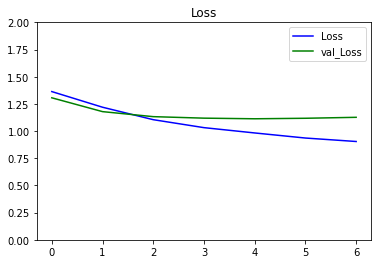

In [85]:
import matplotlib.pyplot as plt

# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=2.0)
word2vec_model.index_to_key


In [86]:
# Test with the following two sentences:
# - 'supercomputer will put workers jobless soon'
# - 'patriots goes winning super bowl'

x_val = np.zeros((2, maximum))
for index, row in enumerate(['supercomputer will put workers jobless soon', 'patriots goes winning super bowl']):
    ix = 0
    for word in tokenizer(row):
        if word not in word2vec_model:
            representation = 0
        else:
            representation = word2vec_model.index_to_key.index(word)
        x_val[index, ix] = representation
        ix += 1
y_val = tf.one_hot([0,1], depth=4)
y_val

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)>